In [10]:
import numpy as np
from fft_tdse import *
from psiviz import *
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



In [50]:
# Set up a fairly large grid

#ng = 4096
#L = 50
ng = 4096*2
L = 50*2
grid = FourierGrid([-L],[L],[ng])
t_final =  4 #3
dt = 0.0005
fskip = 8

x = grid.x[0] 
dx = x[1]- x[0]

# Set up potential 
Vfun0 = lambda x: 0.0
animname = 'free_particle.mp4'
Vfun = lambda xx: Vfun0(xx[0]) # the grid stores the nodes for each dimension in a list ...




Vfun = (x >= 0) * (x <= 1.0) * 50
animname = 'barrier.mp4'



# Fetch the nodes of the grid.

q0 = -15
k0 = 10
sigma0 = 1.0
psi0 = np.exp(-(x-q0)**2/(2*sigma0) + 1j*k0*(x-q0))
psi0 /= np.linalg.norm(psi0) * dx**.5

In [51]:
def visualize(psi,heading):
    """ Visualize the wavefunction. """
    plt.figure()
    plt.plot(x,psi.real,'b',linewidth=.25)
    plt.plot(x,psi.imag,'r',linewidth=.25)
    plt.plot(x,np.abs(psi),'k',linewidth=.5)
    #plt.legend(['Re','Im','abs'])
    plt.xlim((-10,10))
    plt.ylim((-1,1))
    plt.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the top edge are off
        labelleft=False) # labels along the bottom edge are off
    plt.title(heading)
    plt.xlabel('x')
    plt.show()
    

# Set up initial condition and propagator

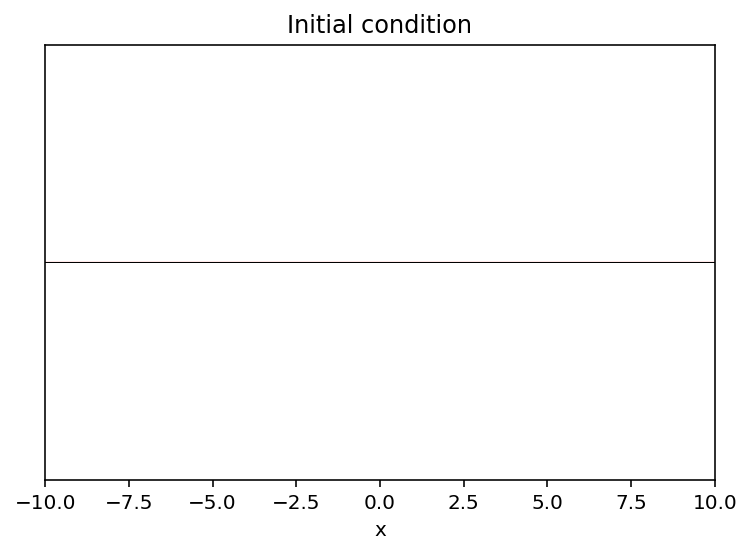

In [52]:
# Set up initial condition.
visualize(psi0,'Initial condition')

# Create a wavefunction object
wf = FourierWavefunction(grid)
wf.setPsi(psi0,normalize=True)

# Set up Hamiltonian
ham = FourierHamiltonian(grid, Vfun = Vfun)

# Create a Strang splitting propagator
prop = Propagator(ham, dt)

# Main simulation loop

The propagation is here. We do a visualization once in a while.

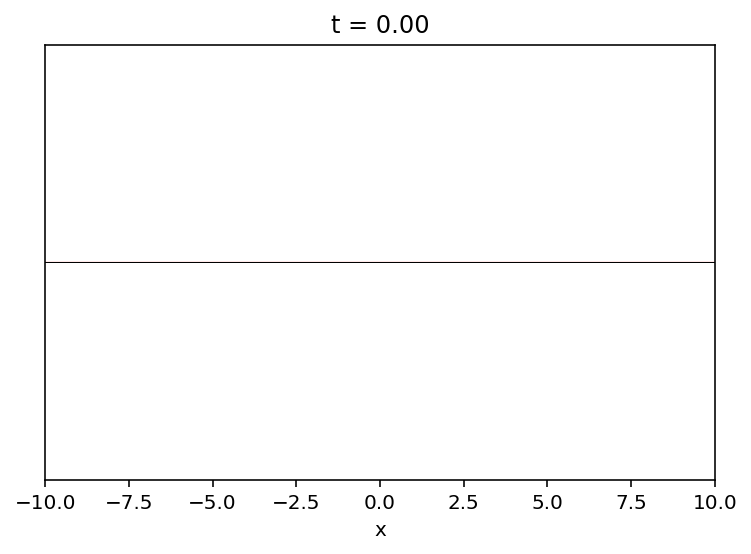

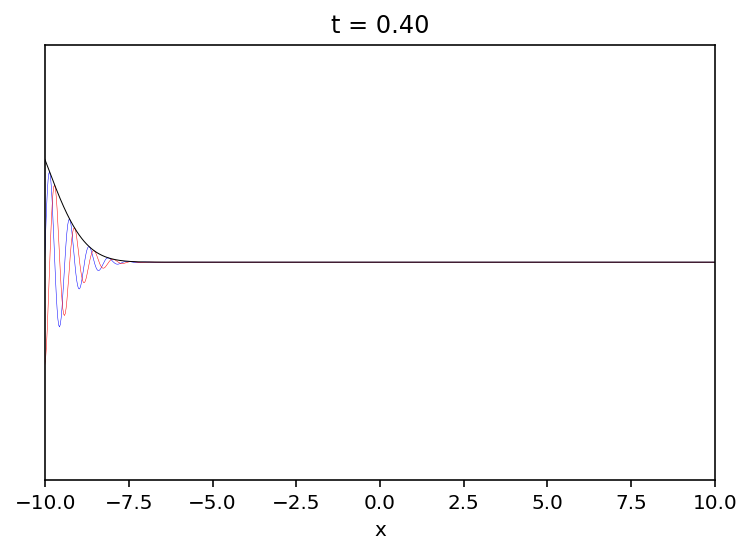

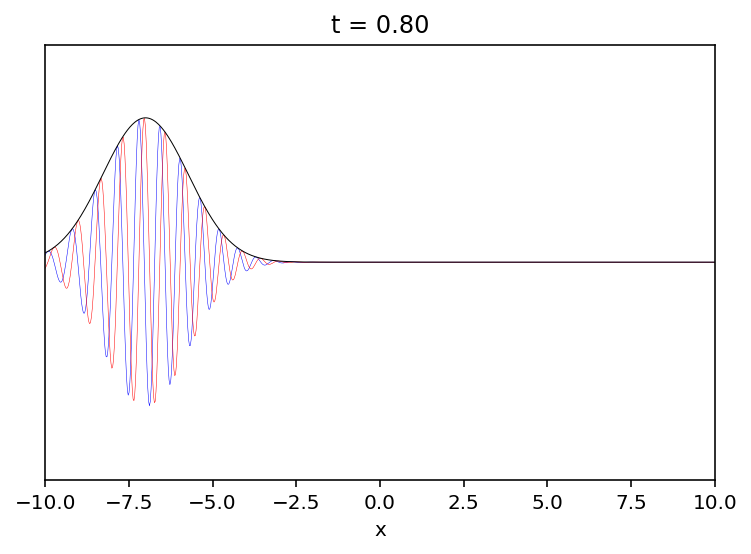

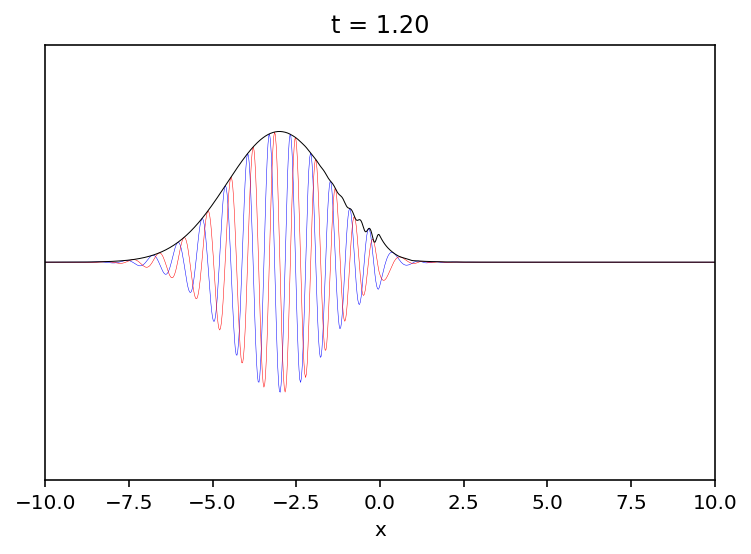

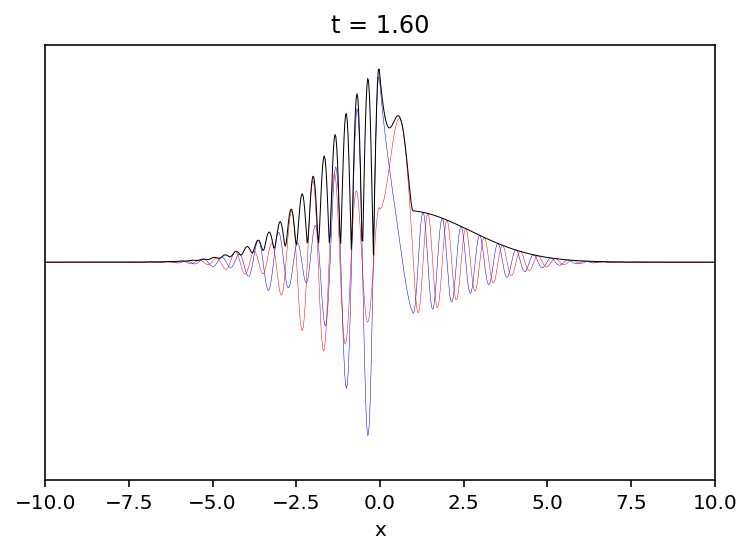

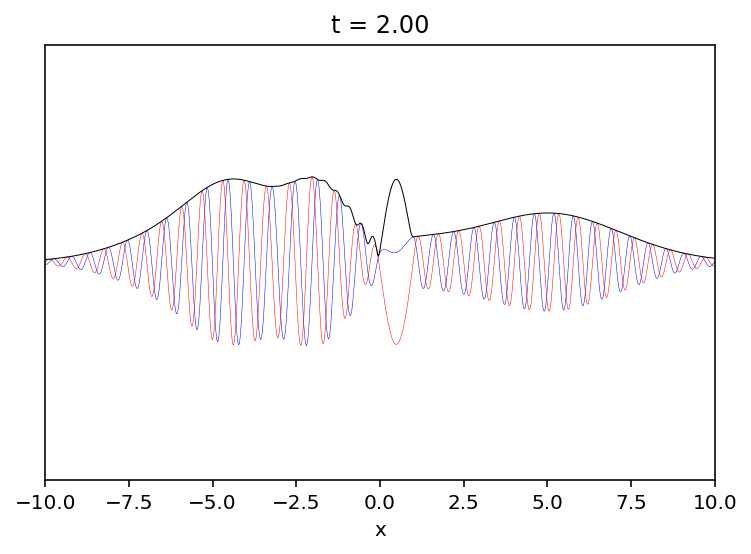

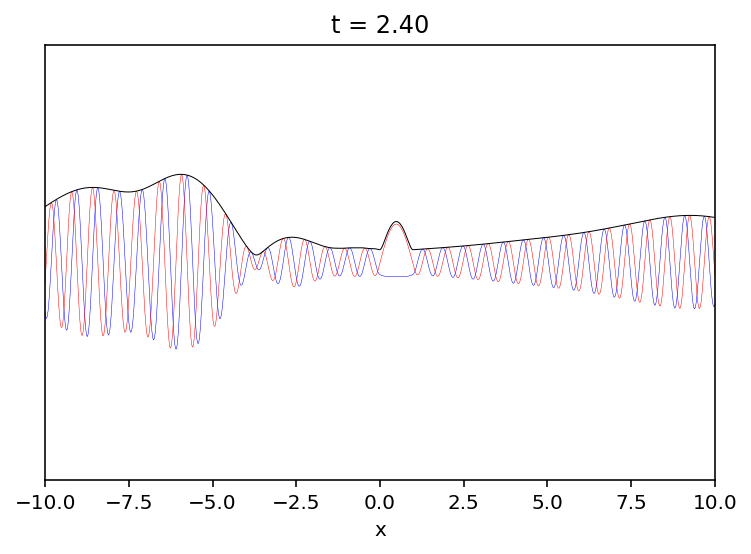

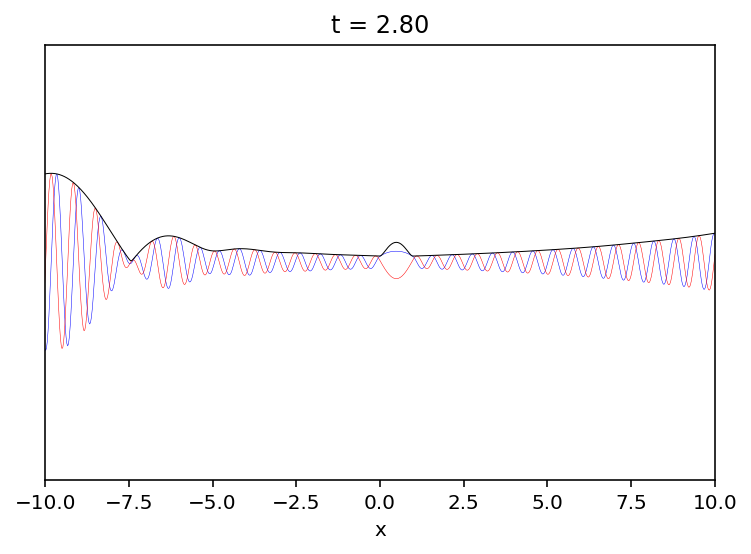

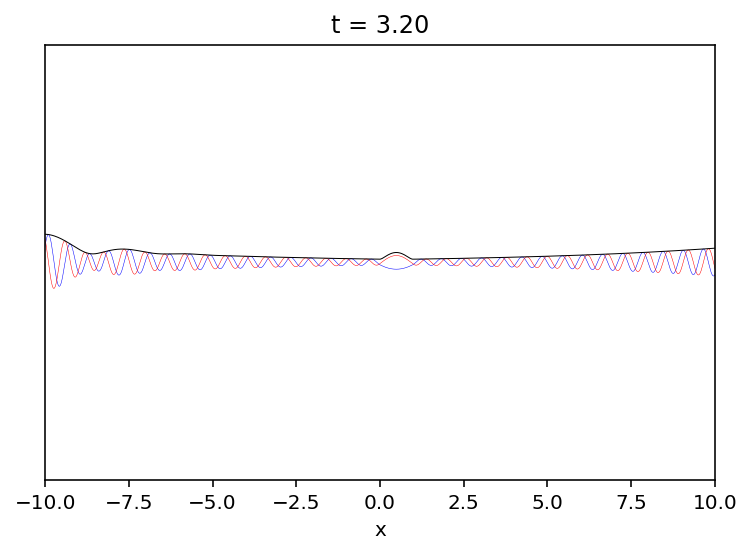

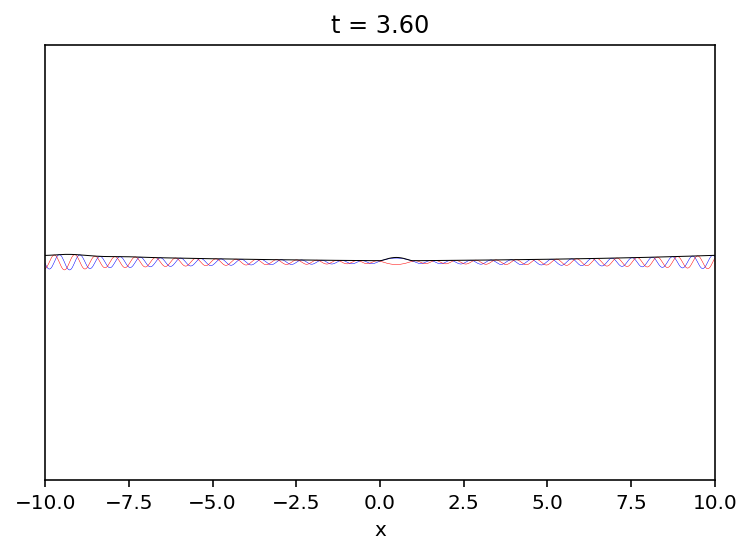

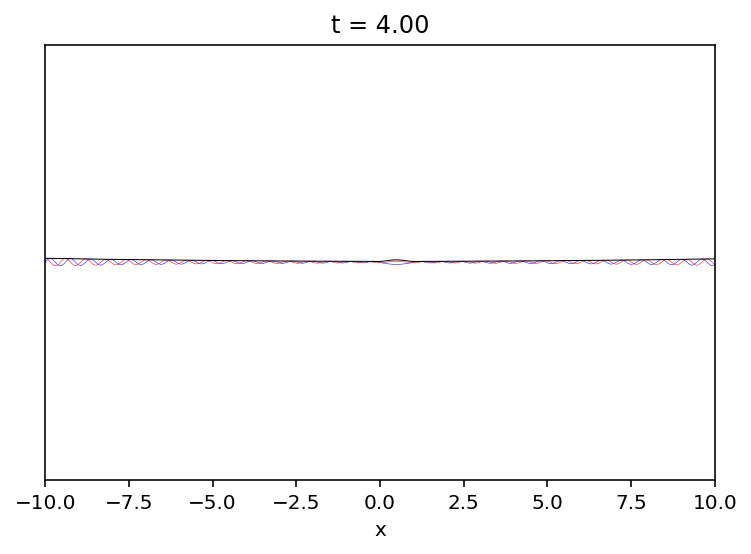

In [53]:
t_range = np.arange(0,t_final+dt,dt)
n_frames = len(t_range)
psi_hist = np.zeros((len(x),len(t_range)), dtype=complex)


for i in range(len(t_range)):
    t = t_range[i]
    psi_hist[:,i] = wf.psi
    if i % int(t_final/10/dt) == 0:
        visualize(wf.psi,f't = {t:.2f}')
    prop.strang(wf,t)


## Visualize entire history

We visualize the entire history of the simulation. The colors represent the phase of the wavefunction.


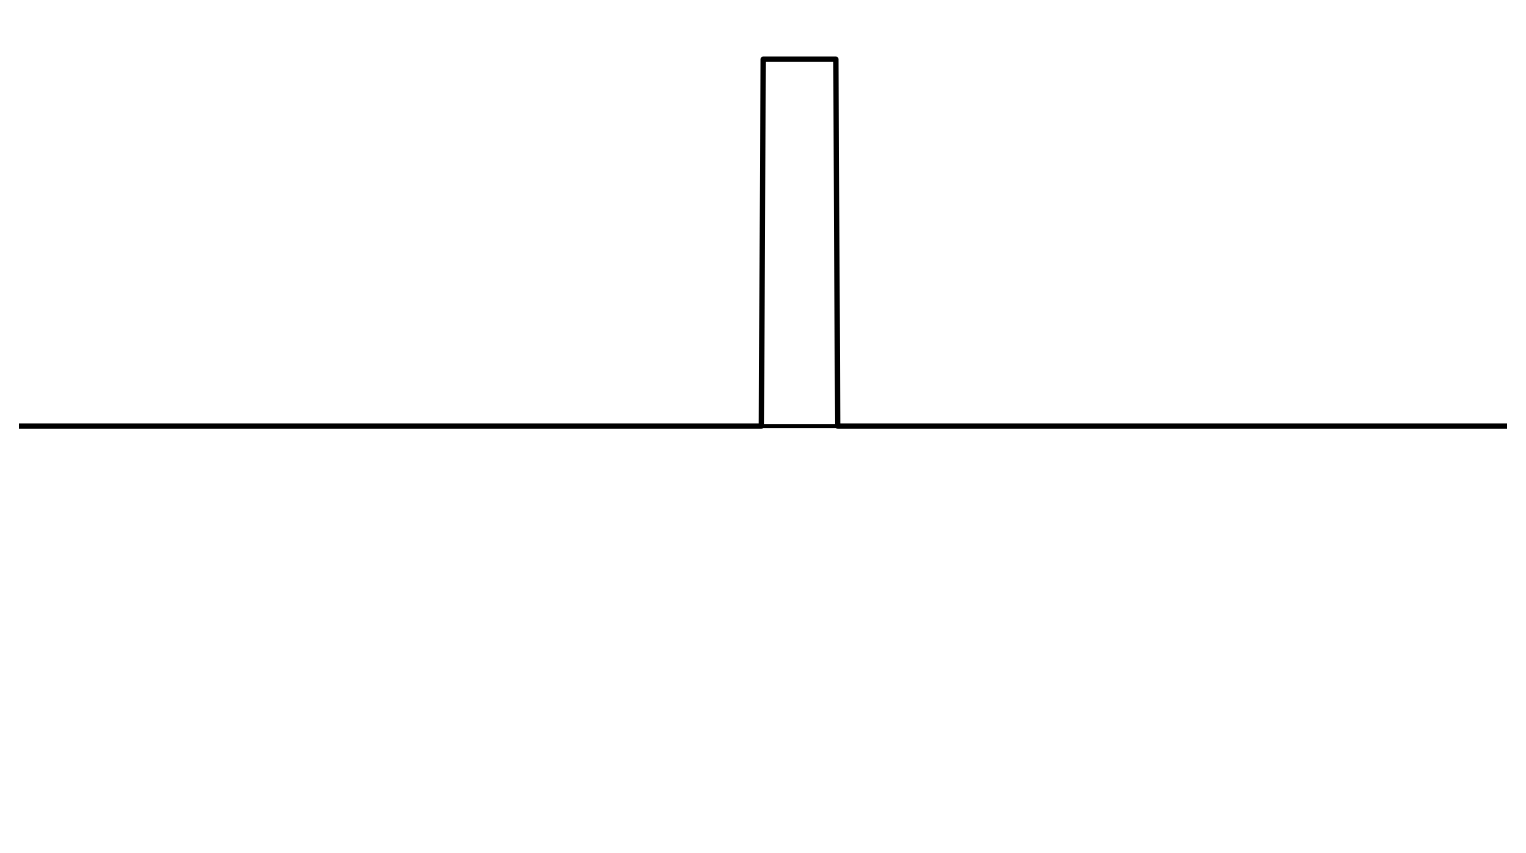

In [59]:
import matplotlib
matplotlib.use('Qt5Agg') #use Qt5 as backend, comment this line for default backend
from matplotlib import animation
from tqdm.notebook import tqdm

dpi = 96
width = 1920
height = 1080 
fig = plt.figure(figsize=[width/dpi/2,height/dpi/2],dpi=dpi)
ax = plt.axes()
ax.axis('off')

psi = psi_hist[:,0]
re_line = plt.plot(x,psi.real,color=(0,0,0.7),linewidth=.75)[0]
im_line = plt.plot(x,psi.imag,color=(0.7,0,0),linewidth=.75)[0]
ab_line = plt.plot(x,np.abs(psi),'k',linewidth=1.5)[0]
if animname == 'barrier.mp4':
    plt.plot(x,Vfun/np.max(Vfun) * .9,'k', linewidth = 2)

plt.xlim((-10,10))
plt.ylim((-1,1))
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelleft=False) # labels along the bottom edge are off
plt.xlabel('x')
    
    
lines = [re_line, im_line, ab_line]

#lines = [line1,line2,line3] #lines to animate
#plt.title('Wavefunction animation')
#plt.legend(['Re psi', 'Im psi', '|psi|'])
#plt.xlabel('x')
#txt = plt.text(0.05, 0.9, 't = %f' % (0), horizontalalignment='left', verticalalignment='center', transform=ax.transAxes)



patches = lines #[img1, txt] # things to animate

def init():
    #init lines

    re_line.set_data(x,psi.real)
    im_line.set_data(x,psi.imag)
    ab_line.set_data(x,np.abs(psi))
    
    #txt.set_text('t = %f' % (0))
    #ax.set_xlim(x0[0], x1[0])
    #ax.set_ylim(y0[0], y1[0])
    
    return patches #return everything that must be updated

def animate(i):
    #animate lines
    #lines[0].set_data(x, psi[:,i].real)
    #lines[1].set_data(x, psi[:,i].imag)
    #lines[2].set_data(x, np.abs(psi[:,i]))
    psi = psi_hist[:,i]
    
    re_line.set_data(x,psi.real)
    im_line.set_data(x,psi.imag)
    ab_line.set_data(x,np.abs(psi))

    #print(f'Frame {i}/{n_frames} done.')
    #ax.set_xlim(x0[i], x1[i])
    #ax.set_ylim(y0[i], y1[i])

    
    return patches #return everything that must be updated

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=tqdm(range(0,n_frames,fskip)), interval=10, blit=False)

plt.show()

plt.rcParams['animation.ffmpeg_path'] = '/users/Simen/Downloads/ffmpeg'
FFwriter=animation.FFMpegWriter(fps=30, extra_args=['-vcodec', 'libx264'])
anim.save(animname, writer=FFwriter)